In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 34.8 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 25.9 MB/s 
     |████████████████████████████████| 636 kB 47.4 MB/s 
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer

import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/mp3_data_w_vectors.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')
data['iGenre'] = data.apply(lambda x:int(x.Genre=='Devotional'),axis=1)

In [4]:
gpu = torch.device("cuda")
cpu = torch.device("cpu")

In [5]:
indic_model = AutoModel.from_pretrained("ai4bharat/indic-bert")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
for param in indic_model.parameters(): 
  param.requires_grad = True

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

In [6]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=25)

In [7]:
txt_results = k_fold_model_preparation(indic_model, gpu, False, data, sequences, attention_masks, targets,
                                       k_folds=5, epochs=5, balance_classes=False)

Running Text Only Classification
FOLD 0
--------------------------------

 Epoch 1 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.669
Validation Loss: 0.654

 Epoch 2 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.646
Validation Loss: 0.652

 Epoch 3 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.612
Validation Loss: 0.619

 Epoch 4 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.566
Validation Loss: 0.644

 Epoch 5 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.538
Validation Loss: 0.686
On Train Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.66      1.00      0.80       581

    accuracy                           0.66       877
   macro avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.607
Validation Loss: 0.532

 Epoch 2 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.523
Validation Loss: 0.475

 Epoch 3 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.468
Validation Loss: 0.452

 Epoch 4 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.421
Validation Loss: 0.431

 Epoch 5 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.390
Validation Loss: 0.419
On Train Data
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       296
           1       0.90      0.93      0.92       581

    accuracy                           0.89       877
   macro avg       0.88      0.87      0.87       877
weighted avg       0.89      0.89      0.89       877

On Test 

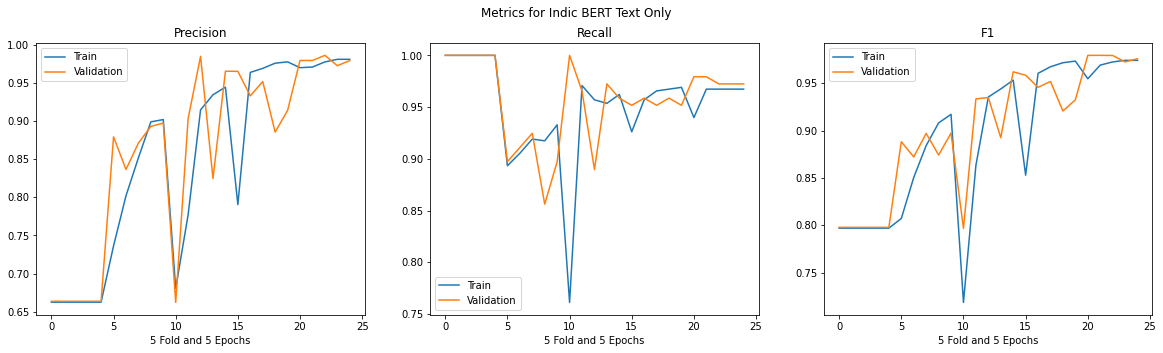

In [8]:
plot_results(txt_results,'Indic BERT Text Only')

In [9]:
fusion_results = k_fold_model_preparation(indic_model, gpu, True, data, sequences, attention_masks, targets,
                             k_folds=5, epochs=5, balance_classes=False)

Running Fusion Model
FOLD 0
--------------------------------

 Epoch 1 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.619
Validation Loss: 0.526

 Epoch 2 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.441
Validation Loss: 0.309

 Epoch 3 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.228
Validation Loss: 0.158

 Epoch 4 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.082
Validation Loss: 0.061

 Epoch 5 / 5
Training Model
  Batch    20  of     55.
  Batch    40  of     55.
Evaluating
Training Loss: 0.038
Validation Loss: 0.068
On Train Data
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       296
           1       0.99      0.98      0.99       581

    accuracy                           0.99       877
   macro avg       0.98    

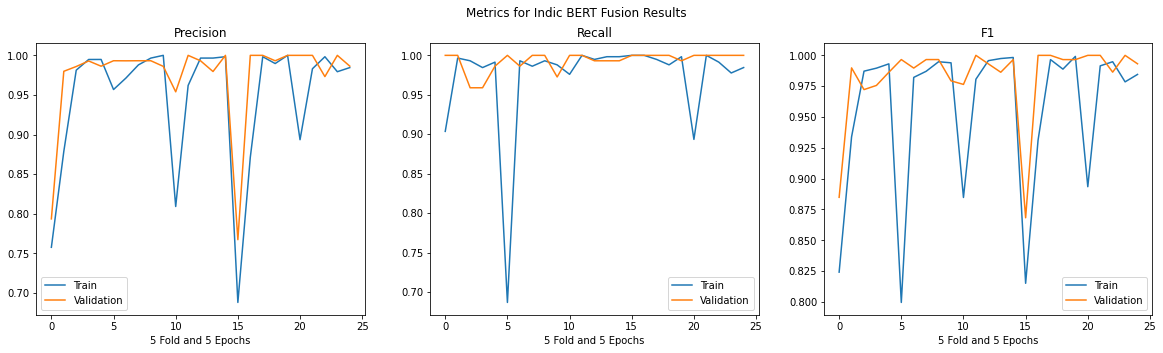

In [10]:
plot_results(fusion_results,'Indic BERT Fusion Results')